In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim
import torch.nn.functional as F
import tqdm
from tqdm import tnrange
import copy

C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=";").astype(float)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


### Split into train, test and val

In [3]:
train = df.iloc[:3686]
val = df.iloc[3686:3886]
test = df.iloc[3886:]

### Split features and labels

In [4]:
X_train, y_train= train.drop('quality', axis=1), train['quality']
print(X_train.shape)

X_val, y_val = val.drop('quality', axis=1), val['quality']
print(X_val.shape)

X_test, y_test = test.drop("quality", axis=1), test["quality"]

(3686, 11)
(200, 11)


### Splitting into batches

In [5]:
f=15 # no. of batches

train_batch = np.array_split(X_train, f) 
label_batch = np.array_split(y_train, f) # 50 sections/batches

val_batch = np.array_split(X_val, f)
val_label_batch = np.array_split(y_val, f)

test_batch = np.array_split(X_test,f) 
test_label_batch  = np.array_split(y_test, f)


for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)
    
for i in range(len(val_batch)):
    val_batch[i] = torch.from_numpy(val_batch[i].values).float()
for i in range(len(val_label_batch)):
    val_label_batch[i] = torch.from_numpy(val_label_batch[i].values).float().view(-1, 1)
    
    
for i in range(len(test_batch)):
    test_batch[i] = torch.from_numpy(test_batch[i].values).float()
for i in range(len(test_label_batch)):
    test_label_batch[i] = torch.from_numpy(test_label_batch[i].values).float().view(-1, 1)
    
print("Batch size:", len(train_batch[0]))


Batch size: 246


### Model class

In [6]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(11, 22)
        self.fc2 = nn.Linear(22, 44)
        self.fc3 = nn.Linear(44, 88)
        self.fc4 = nn.Linear(88, 22)
        self.fc5 = nn.Linear(22, 1)
       
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))

        return x

In [7]:
model = NeuralNet()
train_losses, val_losses = [], []
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) # 0.015 87
total_epochs=0

### Best model

In [8]:
best_model = copy.deepcopy(model)
best_val_loss = None

### Training loop

In [9]:
epochs = 500
total_epochs+=epochs

for e in range(epochs):
    
    model.train()
    train_loss = 0
    val_loss_1=0
    val_loss_sum = 0
    
    for i in range(len(train_batch)):
        
        optimizer.zero_grad()
        output = model(train_batch[i])
        loss = criterion(output, label_batch[i])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
        with torch.no_grad():
            
            for j in range(len(val_batch)):
                
                val_output = model(val_batch[j])
                val_loss =  criterion(val_output, val_label_batch[j])
                val_loss_1+=val_loss.item()
        val_loss_sum=val_loss_1/len(val_batch)
    
    # saving best model
    if best_val_loss is None or val_loss_sum/len(val_batch) < best_val_loss:
        print('Model replaced')
        best_val_loss = val_loss_sum/len(val_batch)
        best_model = copy.deepcopy(model)
        
    print("Epoch :", e, "train_loss :", train_loss/len(train_batch), "Val loss: ", val_loss_sum/len(val_batch))    
    val_losses.append(val_loss_sum/len(val_batch))    
    train_losses.append(train_loss/len(train_batch))   

Model replaced
Epoch : 0 train_loss : 10.361927922566732 Val loss:  8.430127485063341
Model replaced
Epoch : 1 train_loss : 4.102780453364054 Val loss:  3.457207173241509
Model replaced
Epoch : 2 train_loss : 2.1209646900494894 Val loss:  1.7773673338360256
Model replaced
Epoch : 3 train_loss : 1.0742449522018434 Val loss:  1.0816910573509004
Model replaced
Epoch : 4 train_loss : 0.8214005986849467 Val loss:  0.7859646892878744
Model replaced
Epoch : 5 train_loss : 0.7568466186523437 Val loss:  0.710649874177244
Model replaced
Epoch : 6 train_loss : 0.699523389339447 Val loss:  0.6751425035132302
Model replaced
Epoch : 7 train_loss : 0.6909737785657247 Val loss:  0.6469513066940837
Model replaced
Epoch : 8 train_loss : 0.6773162364959717 Val loss:  0.6332904377910825
Model replaced
Epoch : 9 train_loss : 0.667650039990743 Val loss:  0.6195520831147829
Model replaced
Epoch : 10 train_loss : 0.6609865109125773 Val loss:  0.6168559823102421
Model replaced
Epoch : 11 train_loss : 0.6572136

### Training vs validation loss plot

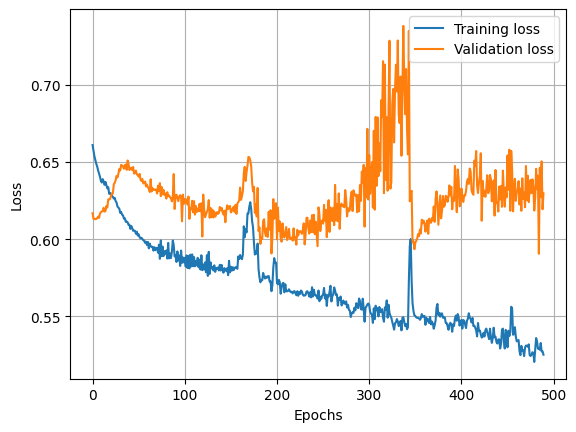

In [10]:
frm=10 # does not 
plt.plot(train_losses[frm:], label='Training loss')
plt.plot(val_losses[frm:], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

### Performance on test-set - model from last iteration

In [11]:
correct=0
i=0
res=[]
with torch.no_grad():
    for batch in test_batch :
        for j in range(len(batch)):
            x = model(batch[j])
            res.append(round(x.item()))

true_labels = list(test["quality"])

for i in range(len(res)):
    if res[i]==int(true_labels[i]):
        correct+=1
        
print("Accuracy:", 100 * (correct/len(res)), "%")

Accuracy: 55.434782608695656 %


### Performance on test-set - best model


In [12]:
correct=0
i=0
res=[]
with torch.no_grad():
    for batch in test_batch :
        for j in range(len(batch)):
            x = best_model(batch[j])
            res.append(round(x.item()))

true_labels = list(test["quality"])

for i in range(len(res)):
    if res[i]==int(true_labels[i]):
        correct+=1
        
print("Accuracy:", 100 * (correct/len(res)), "%")

Accuracy: 52.27272727272727 %


In [13]:
model == best_model

False